# Inference and post-processing

In [25]:
from ultralytics import YOLO
from PIL import Image, ImageOps 
import PIL
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import numpy as np
import pandas as pd
from pathlib import Path
import os

from utils import find_bounding_box

from PIL import Image, ImageFilter

In [26]:
ROOT_DIR = Path(".")
model_path = ROOT_DIR / "datasets" / "results" / "200m_epochs-" / "weights" / "best.pt"
data_path = ROOT_DIR / "Scansioni"

model = YOLO(model_path)

PIXEL_CM_RATIO = 118.11

Read the tabular data

In [27]:
df_info = pd.read_excel("Tavolette_Sigle_unico.xlsx")

In [28]:
df_info

,TAV,INV (PT),DIAM (cm),RIB
0,1,777,48.0,0
1,1,300,29.0,0
2,1,301,47.0,0
3,1,818,33.0,1
4,1,30,28.0,1
...,...,...,...,...
308,69,1259,26.0,1
309,69,517,32.0,0
310,70,1006,38.0,1
311,70,1192,24.0,1


In [29]:
img_path = data_path / os.listdir(data_path)[1]

In [30]:
data_path

WindowsPath('Scansioni')

In [31]:
img_path

WindowsPath('Scansioni/1.tif')

In [32]:
img_path.name.split(".")[0]

'1'

In [33]:
img_try = Image.open(img_path)
tab = img_path.name.split(".")[0]

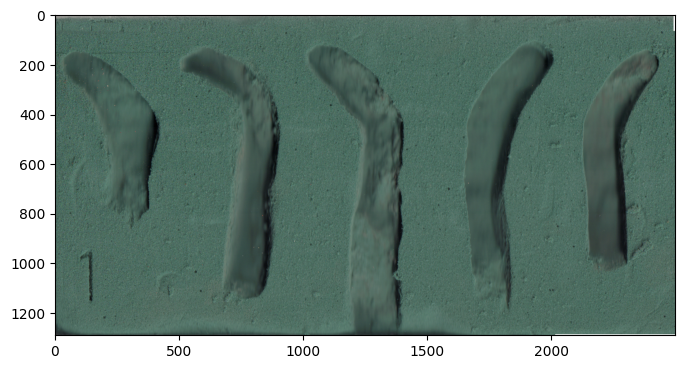

In [34]:
plt.figure(figsize=(8, 8))
plt.imshow(img_try)
plt.show()

Apply the model to the data

In [35]:
results = model.predict(img_try, save_crop=False, conf = 0.5, retina_masks = True)


0: 416x800 5 Profiles, 464.3ms
Speed: 0.0ms preprocess, 464.3ms inference, 74.4ms postprocess per image at shape (1, 3, 416, 800)


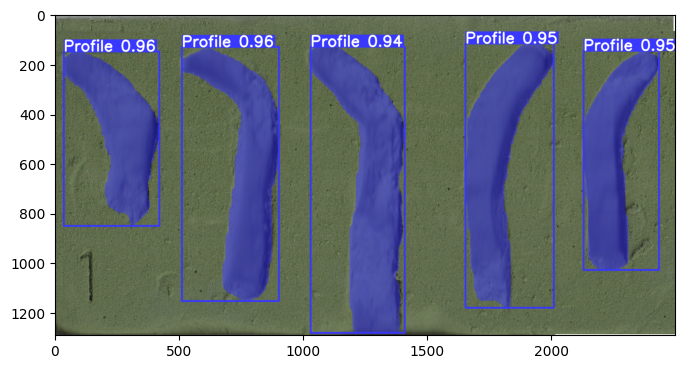

In [36]:
result_array = results[0].plot(masks=True)
plt.figure(figsize=(8, 8))
plt.imshow(result_array)
plt.show()

In [37]:
extracted_masks = results[0].masks.data
masks_array = extracted_masks.cpu().numpy()

Extract the tav order

In [38]:
order = []

for i in range(len(masks_array)):
    num = find_bounding_box(masks_array[i])[2]
    order.append((i, num))


### sort the masks by the x coordinate of the bounding box
order.sort(key=lambda x: x[1])

And select the corresponding tabular data

In [39]:
df_info_tab = df_info.loc[df_info["TAV"] == int(tab)]

In [40]:
df_info_tab

,TAV,INV (PT),DIAM (cm),RIB
0,1,777,48.0,0
1,1,300,29.0,0
2,1,301,47.0,0
3,1,818,33.0,1
4,1,30,28.0,1


In [41]:
df_info_tab["RIB"] = df_info_tab["RIB"].astype(bool)

C:\Users\larth\AppData\Local\Temp\ipykernel_11924\85804711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info_tab["RIB"] = df_info_tab["RIB"].astype(bool)


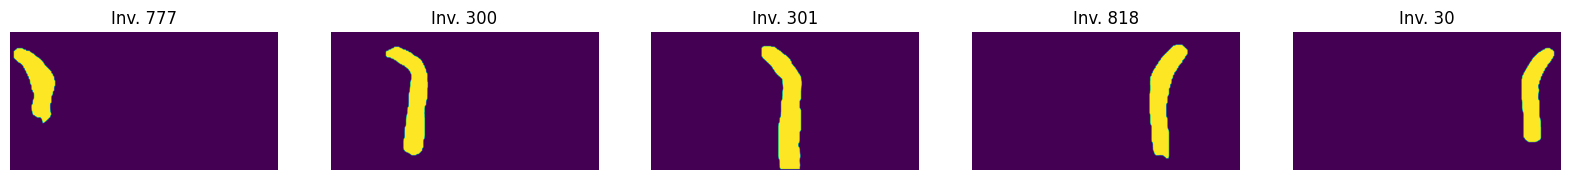

In [42]:
fig, ax = plt.subplots(1, len(masks_array), figsize=(20, 20))

img_list = []

for i in range(len(masks_array)):
    ax[i].imshow(masks_array[order[i][0]])
    ax[i].axis("off")
    ax[i].set_title(f"Inv. {df_info_tab.iloc[i]['INV (PT)'].astype(int)}")
    img_list.append(Image.fromarray(masks_array[order[i][0]].astype(np.uint8) * 255))

In [43]:
img_list_processed = [img.filter(ImageFilter.ModeFilter(size=10)) for img in img_list] #50

In [44]:
img_array_processed = np.array(img_list_processed)

In [45]:
img_array_processed.shape

(5, 1290, 2499)

In [46]:
mask_list = []

for i in range(len(img_array_processed)):
    # get the bounding box of the mask
    rmin, rmax, cmin, cmax = find_bounding_box(img_array_processed[i])
    ## extract the mask
    mask = img_array_processed[i][rmin:rmax, cmin:cmax]

    mask = mask / 255

    if df_info_tab.iloc[i]["RIB"]:
        mask = np.flip(mask, axis=1)

    mask_list.append(mask)
    

In [47]:
len(mask_list)

5

In [48]:
if len(mask_list) != len(df_info_tab):
    print("Error: the number of masks does not match the number of inscriptions")

In [49]:
processed_imgs = []

for ids, mask in enumerate(mask_list[0:2]):
    
    ### for each row, get the first and pixel of the mask
    first_pixel = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == 1:
                first_pixel.append((i, j))
                break

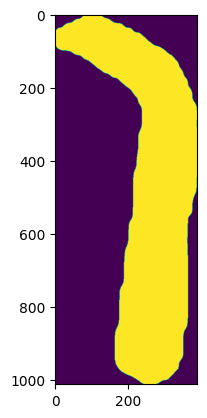

In [50]:
plt.imshow(mask)

In [51]:
first_pixel[0]

(0, 83)

In [52]:
first_pixel[-1]

(1012, 241)

In [53]:
first_pixel[0][1]

83

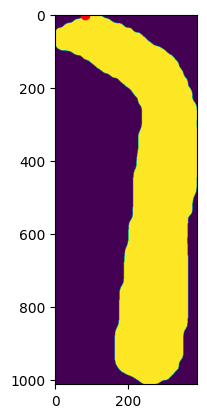

In [54]:
plt.imshow(mask)
plt.scatter(first_pixel[0][1], first_pixel[0][0], c="r")
#plt.scatter(first_pixel[-1][1], first_pixel[-1][0], c="r")

In [55]:
from skimage import measure

In [56]:
# Trova i contorni nell'immagine
contours = measure.find_contours(np.pad(mask, (1,1)))

# Crea un'immagine vuota per disegnare i contorni
contour_image = np.zeros_like(np.pad(mask, (1,1)))

my_list = []

# Disegna i contorni sull'immagine vuota
for contour in contours:
    for coord in contour:
        x, y = int(coord[0]), int(coord[1])
        contour_image[x, y] = 1
        my_list.append((x,y))

contour_image_2 = np.zeros_like(contour_image)


first_possibile_value = [first_pixel[0][1] + 1, first_pixel[0][1], first_pixel[0][1]-1]
second_possibile_value = [first_pixel[0][0] + 1, first_pixel[0][0], first_pixel[0][0]-1]

values = []
for possible_value in first_possibile_value:
    for second_possible_value in second_possibile_value:
        if contour_image[second_possible_value, possible_value] == 1:
            values.append((second_possible_value, possible_value))

## find the index of the first pixel in the contour
index = my_list.index(values[0])


for x, y in my_list[:index]:
            contour_image_2[x, y] = 1




### for each row, get the first and pixel of the mask
first_pixel = []
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i, j] == 1:
            first_pixel.append((i, j))
            break

### remove the fraction of the first pixel using the gradient
gradients = np.gradient(np.array(first_pixel)[:, 1], axis=0)
zero_gradient_mask = gradients == 0
last_zero_gradient = np.where(zero_gradient_mask)[0][-1]
                
# get the diameter of the pot in pixel
diam_pix = df_info_tab.iloc[ids]["DIAM (cm)"] * PIXEL_CM_RATIO

#if diam_pix > 0:
### create a mask with the first pixel of each row
first_pixel_mask = np.zeros_like(mask)
for i, j in first_pixel:
    if i < last_zero_gradient:
        first_pixel_mask[i, j] = 1
    elif i > last_zero_gradient and i > len(first_pixel)//2:
        first_pixel_mask[i, j] = 0

### get the bounding box of the mask

### 

In [57]:
### finds the max values of the index of the mask

max_values = np.max(np.where(first_pixel_mask), axis=1)

In [58]:
max_values

array([954, 237], dtype=int64)

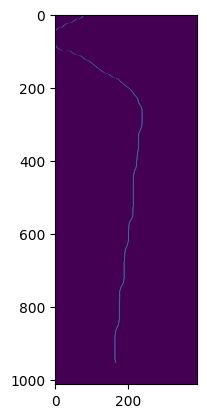

In [59]:
plt.imshow(first_pixel_mask)


In [60]:
contour_image_2[max_values[0]:, :] = 0

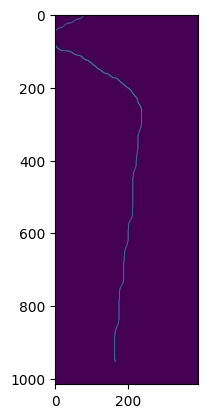

In [61]:
plt.imshow(contour_image_2)

In [112]:
first_pixel[0][1], first_pixel[0][0]

(70, 0)

In [113]:
first_possibile_value = [first_pixel[0][1] + 1, first_pixel[0][1], first_pixel[0][1]-1]
second_possibile_value = [first_pixel[0][0] + 1, first_pixel[0][0], first_pixel[0][0]-1]

In [114]:
first_possibile_value, second_possibile_value

([71, 70, 69], [1, 0, -1])

In [115]:
values = []
for possible_value in first_possibile_value:
    for second_possible_value in second_possibile_value:
        if contour_image[second_possible_value, possible_value] == 1:
            values.append((second_possible_value, possible_value))


In [116]:
values[0]

(0, 71)

In [117]:
## find the index of the first pixel in the contour
index = my_list.index(values[0])

In [118]:
index

1006

In [119]:
for x, y in my_list[:index]:
        contour_image_2[x, y] = 1

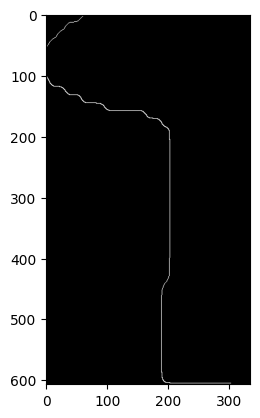

In [120]:
plt.imshow(np.pad(contour_image_2, ((0, 0), (0,0))), cmap='gray')
#plt.plot(first_pixel[0][1], first_pixel[0][0], 'ro')
#plt.scatter(y, x, c='r', s=1)

In [43]:
processed_imgs = []

for ids, mask in enumerate(mask_list):
    
    ### for each row, get the first and pixel of the mask
    first_pixel = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == 1:
                first_pixel.append((i, j))
                break
    
    ### remove the fraction of the first pixel using the gradient
    gradients = np.gradient(np.array(first_pixel)[:, 1], axis=0)
    zero_gradient_mask = gradients == 0
    last_zero_gradient = np.where(zero_gradient_mask)[0][-1]
    
    # get the diameter of the pot in pixel
    diam_pix = df_info_tab.iloc[ids]["DIAM (cm)"] * PIXEL_CM_RATIO

    ### create a mask with the first pixel of each row
    first_pixel_mask = np.zeros_like(mask)
    for i, j in first_pixel:
        if i < last_zero_gradient:
            first_pixel_mask[i, j] = 1
        elif i > last_zero_gradient and i > len(first_pixel)//2:
            first_pixel_mask[i, j] = 0
        #else:
        #   first_pixel_mask[i, j] = 0

    ### dilate the mask
    first_pixel_mask = binary_dilation(first_pixel_mask, iterations=5)

    ### real dimension of the pot in pixel
    empty_mask = np.zeros((mask.shape[0],int(diam_pix + first_pixel[0][1]*2)))


    ### apply the mask and the first pixel mask to the empty mask
    empty_mask[:, :mask.shape[1]] = mask
    empty_mask_flipped = np.flip(empty_mask, axis=1)
    empty_mask_flipped[:, :mask.shape[1]] = first_pixel_mask
    empty_mask = np.flip(empty_mask_flipped, axis=1)

    ### create the diameter rim mask
    empty_mask[0:5, :] = 1


    ### remove the diameter rim mask outside the profile and the first pixel mask
    empty_mask = np.flip(empty_mask, axis=1)

    for i, j in first_pixel:
        empty_mask[i, :j] = 0

    empty_mask = np.flip(empty_mask, axis=1)

    for i, j in first_pixel:
        empty_mask[i, :j] = 0

    
    ### create the symmetry mask
    empty_mask[:, empty_mask.shape[1] // 2: empty_mask.shape[1] // 2+5] = 1


    ### add a padding to the mask
    res = np.pad(empty_mask, ((100, 100), (100, 100)), mode="constant", constant_values=0)

    processed_imgs.append(res)

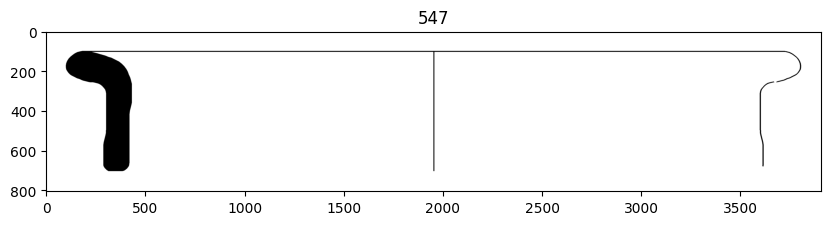

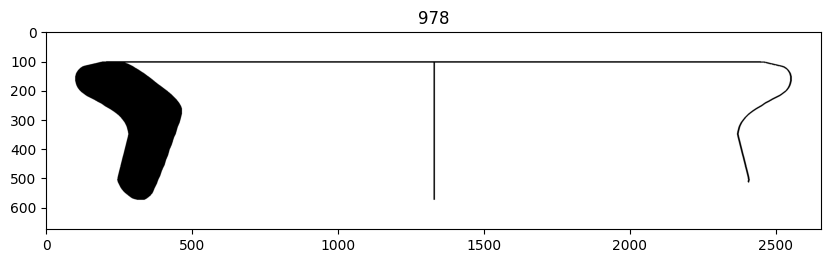

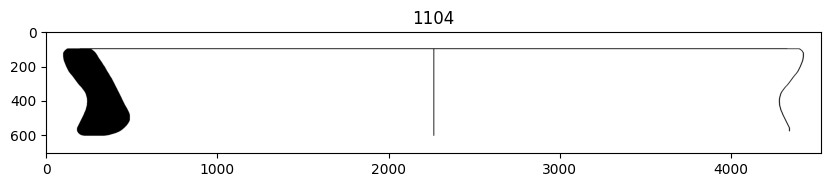

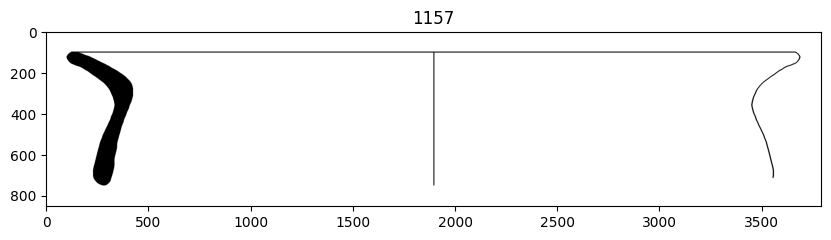

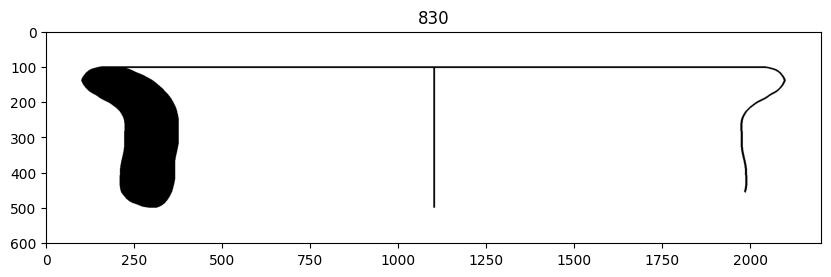

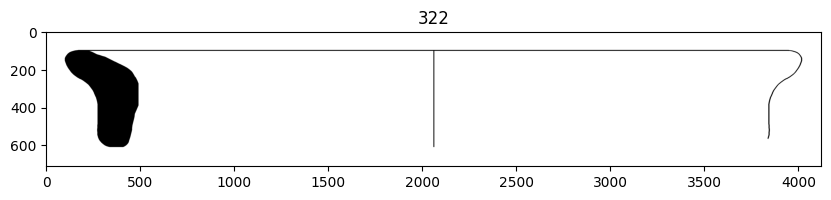

In [24]:
for ids, img in enumerate(processed_imgs):

    fig, ax = plt.subplots(1, figsize=(10, 10))

    ax.imshow(1-img, cmap="gray")

    ax.set_title(f"{df_info_tab.iloc[ids]['INV (PT)'].astype(int)}")

    ### save the img

    plt.savefig(f"processed_imgs/{df_info_tab.iloc[ids]['INV (PT)'].astype(int)}.png", bbox_inches="tight")

